In [3]:
import gunpowder as gp
import zarr
import matplotlib.pyplot as plt
import os

In [4]:
ZARR_FOLDER = '../../../../data/cells/raw/zarr/'
raw = gp.ArrayKey('raw')
gt = gp.ArrayKey('ground_truth')
files = os.listdir(ZARR_FOLDER)
files = [os.path.join(ZARR_FOLDER,f) for f in files ]
files

['../../../../data/cells/raw/zarr/20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_1_ch_4.zarr',
 '../../../../data/cells/raw/zarr/ND8_DIV0+4h_20x_noConfinment_6_ch_4.zarr']

#### TODO
- add data augmentation
- add elastic

In [8]:
def generate_fast_training_pair(files, voxel_shape = [1,1,1],input_shape= [240, 240,4 ],output_shape = [ 240, 240,4] ):
    pipeline =( tuple (
        gp.ZarrSource(
            files[t],  # the zarr container
            {raw: 'raw', gt : 'ground_truth'},  # which dataset to associate to the array key
            {raw: gp.ArraySpec(interpolatable=True),
             gt: gp.ArraySpec(interpolatable=True)}  # meta-information
        )
        + gp.RandomLocation()
        for t in range(len(files))
    )
               + gp.RandomProvider()
              )
    voxel_size = gp.Coordinate(voxel_shape)
    input_size = gp.Coordinate(input_shape)*voxel_size
    output_size = gp.Coordinate(output_shape)*voxel_size
    
    request = gp.BatchRequest()
    request.add(raw,input_shape)
    request.add(gt,output_shape)
    
    while 1:
        with gp.build(pipeline):
            batch = pipeline.request_batch(request)
            yield batch[raw].data, batch[gt].data
               

def generate_fast_training_batch(files, batch_size=12,voxel_shape = [1,1,1],input_shape= [256, 256,4 ],output_shape = [ 256, 256,4] ):
    pipeline =( tuple (
        gp.ZarrSource(
            files[t],  # the zarr container
            {raw: 'raw', gt : 'ground_truth'},  # which dataset to associate to the array key
            {raw: gp.ArraySpec(interpolatable=True),
             gt: gp.ArraySpec(interpolatable=True)}  # meta-information
        )
        + gp.RandomLocation()
        for t in range(len(files))
    )
               + gp.RandomProvider()
               +gp.Stack(batch_size)
              )
    voxel_size = gp.Coordinate(voxel_shape)
    input_size = gp.Coordinate(input_shape)*voxel_size
    output_size = gp.Coordinate(output_shape)*voxel_size
    
    request = gp.BatchRequest()
    request.add(raw,input_size)
    request.add(gt,output_size)
    
    while 1:
        with gp.build(pipeline):
            batch = pipeline.request_batch(request)
            yield batch[raw].data, batch[gt].data

In [9]:
gen_train_fast = generate_fast_training_batch(files)
bimg,blbl = next(gen_train_fast)
bimg.shape, blbl.shape

((12, 256, 256, 4), (12, 256, 256, 4))

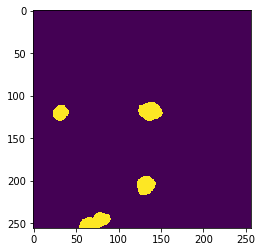

In [12]:
plt.imshow(blbl[0][:,:,2])